In [1]:
# Monta o Google Drive para acessar arquivos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from tqdm import tqdm
from google.colab import files

import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageEnhance

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

# 1- Acessando os dados x e y coletados pelos grupos a partir de um .h5

In [3]:
data_set_path = '/content/drive/MyDrive/PROJETO/XandYDataset.h5'

x = []
y = []

with h5py.File(data_set_path, 'r') as h5_file:
    # Listando os grupos/datasets no arquivo
    print("Chaves no arquivo:", list(h5_file.keys()))

    # Acessando e lendo os dados dos datasets
    x = h5_file['x'][:]
    y = h5_file['y'][:]

# Verificando as dimensões dos dados carregados
x.shape, y.shape

Chaves no arquivo: ['x', 'y']


((3988, 128, 128, 3), (3988, 128, 128, 3))

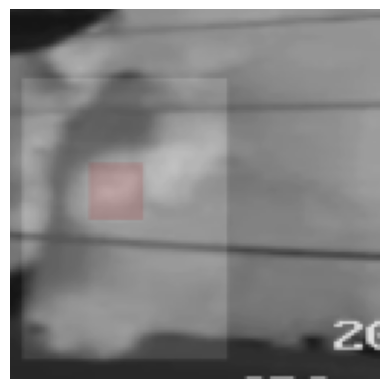

In [46]:
plt.imshow(x[10], cmap='gray')
plt.imshow(y[10], cmap='jet', alpha=0.1)
plt.axis('off')

plt.show()

# 2- Dividindo os dados em conjunto de treino e teste

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=56)

In [18]:
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (3190, 128, 128, 3)
Shape de X_test: (798, 128, 128, 3)
Shape de y_train: (3190, 128, 128, 3)
Shape de y_test: (798, 128, 128, 3)


# 3- Data Augmentation

In [54]:
def apply_data_augmentation(X, y, variations=2):

    X_augmented = []
    y_augmented = []

    datagen = ImageDataGenerator(
        rotation_range=5,
        zoom_range=0.2,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    for i in range(X.shape[0]):

        image = X[i]
        mask = y[i]

        if image.ndim == 4:
            image = image.squeeze()
        if mask.ndim == 4:
            mask = mask.squeeze()

        X_augmented.append(image)
        y_augmented.append(mask)

        for j in range(variations):
            params = datagen.get_random_transform(image.shape)

            augmented_image = datagen.apply_transform(image, params)
            augmented_mask = datagen.apply_transform(mask, params)

            X_augmented.append(augmented_image)
            y_augmented.append(augmented_mask)

    return np.array(X_augmented), np.array(y_augmented)

X_train_augmented, y_train_augmented = apply_data_augmentation(X_train, y_train)

In [56]:
X_train_augmented = X_train_augmented / 255.0
y_train_augmented = y_train_augmented / 255.0

X_test = X_test / 255.0
y_test = y_test / 255.0

In [61]:
X_test = X_test.squeeze()
y_test = y_test.squeeze()

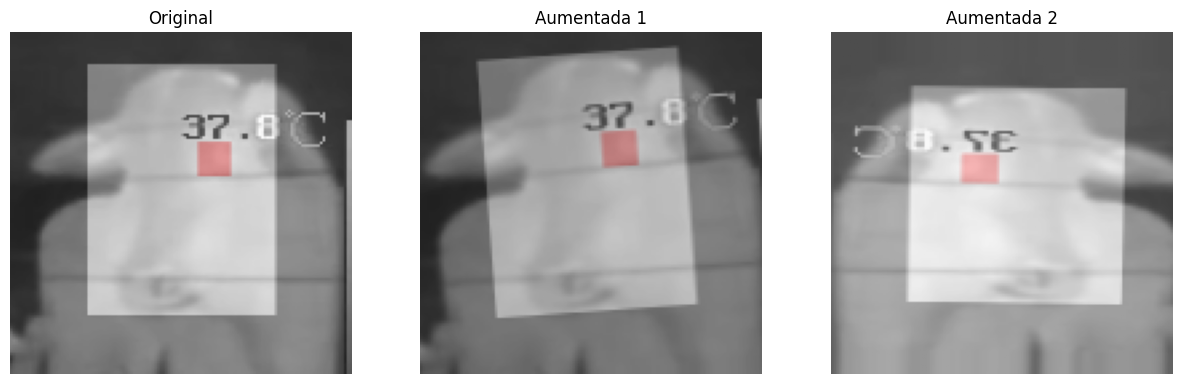

In [64]:
idx = 6
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

images = [X_train_augmented[idx], X_train_augmented[idx+1], X_train_augmented[idx+2]]
masks = [y_train_augmented[idx], y_train_augmented[idx+1], y_train_augmented[idx+2]]
titles = ['Original', 'Aumentada 1', 'Aumentada 2']

for i in range(3):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].imshow(masks[i], cmap='jet', alpha=0.3)  # Overlay the mask
    axs[i].set_title(titles[i])
    axs[i].axis('off')


plt.show()

# 4- Pré-processamento das imagens

## 4.1- Garantindo que as máscaras(conjunto y) possuam apenas a cores: preto, branco e vermelho.

In [65]:
def reduce_colors(img_array, colors):
    assert img_array.shape == (128, 128, 3), "Input array must have shape (128, 128, 3)"
    fixed_colors = np.array(colors)
    pixels = img_array.reshape(-1, 3)
    distances = np.sqrt(((pixels[:, np.newaxis, :] - fixed_colors) ** 2).sum(axis=2))
    nearest_color_indices = distances.argmin(axis=1)
    new_img = fixed_colors[nearest_color_indices].reshape(img_array.shape)
    return (new_img * 255).astype('uint8')

def reduce_colors_dataset(dataset, colors):
    return np.array([reduce_colors(img, colors) for img in tqdm(dataset, desc="Processing images")])

In [66]:
colors = [
    (1.0, 1.0, 1.0),  # White
    (1.0, 0.0, 0.0),  # Red
    (0.0, 0.0, 0.0)   # Black
]

y_train_reduced = reduce_colors_dataset(y_train_augmented, colors)
y_test_reduced = reduce_colors_dataset(y_test, colors)

Processing images: 100%|██████████| 798/798 [00:02<00:00, 349.56it/s]


## 4.2- Melhorando o contraste do conjunto x

In [9]:
def process_images(X_train, X_test):

    def apply_clahe(image):
        image_gray = (image * 255).astype(np.uint8)
        image_gray = cv2.cvtColor(image_gray, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(2, 2))
        image_clahe = clahe.apply(image_gray)
        image_clahe_rgb = cv2.cvtColor(image_clahe, cv2.COLOR_GRAY2RGB)
        return image_clahe_rgb / 255.0

    def adjust_contrast(image, factor):
        image_pil = Image.fromarray((image * 255).astype(np.uint8))
        enhancer = ImageEnhance.Contrast(image_pil)
        image_pil = enhancer.enhance(factor)
        return np.array(image_pil) / 255.0

    def process_single_image(image):
        clahe_image = apply_clahe(image)
        adjusted_image = adjust_contrast(clahe_image, 1.5)
        return adjusted_image

    X_train_processed = np.array([process_single_image(img) for img in X_train])
    X_test_processed = np.array([process_single_image(img) for img in X_test])

    return X_train_processed, X_test_processed

In [10]:
X_train_processed, X_test_processed = process_images(X_train_augmented.copy(), X_test.copy())

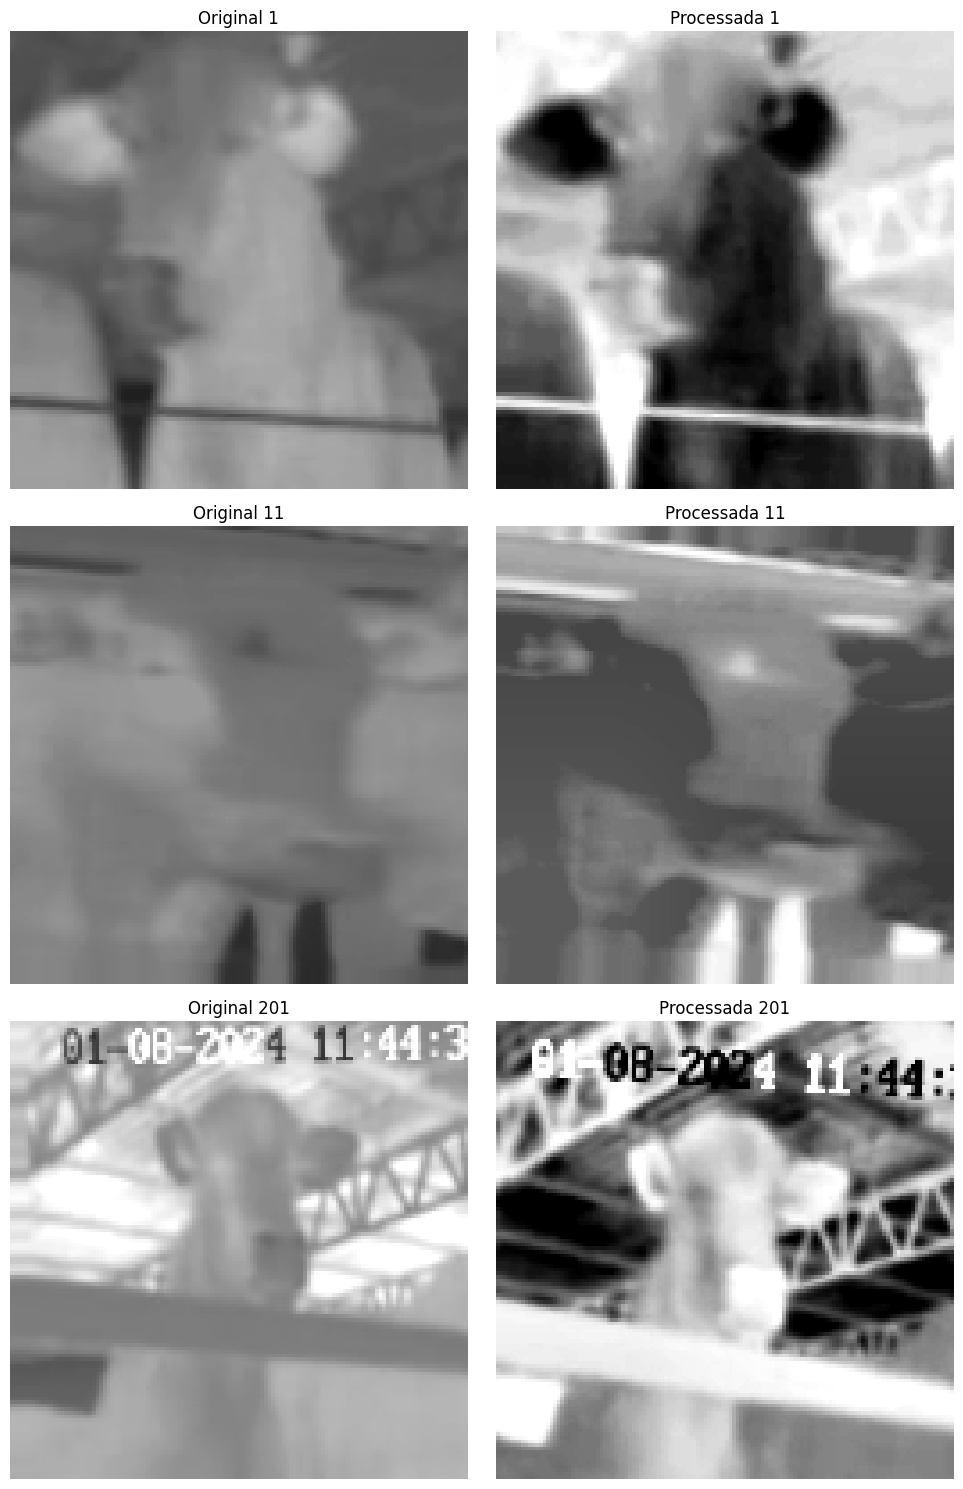

In [69]:
# Índices das imagens que você quer visualizar
indices = [0, 10, 200]

fig, axs = plt.subplots(len(indices), 2, figsize=(10, 15))

for i, idx in enumerate(indices):
    # Imagem original
    axs[i, 0].imshow(X_train_augmented[idx], cmap='gray')
    axs[i, 0].set_title(f'Original {idx+1}')
    axs[i, 0].axis('off')

    # Imagem processada
    axs[i, 1].imshow(X_train_processed[idx], cmap='gray')
    axs[i, 1].set_title(f'Processada {idx+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


# 5- Exportando h5 de dados processados

In [70]:
# Caminho para salvar o arquivo no Google Drive
file_path = '/content/drive/MyDrive/PROJETO/g5_dataset_augmented_processed_28_ago.h5'

# Salvando os arrays no arquivo HDF5
with h5py.File(file_path, 'w') as h5f:
    h5f.create_dataset('x_train', data=X_train_processed)
    h5f.create_dataset('x_test', data=X_test_processed)
    h5f.create_dataset('y_train', data=y_train_reduced)
    h5f.create_dataset('y_test', data=y_test_reduced)